In [1]:
from src.geoadmin import load_neighborhoods
import fiona

NAME = 'Boyle Heights'

bp = 'data/laraic_files/LARIAC6_Buildings_2020.gdb'

with fiona.open(bp) as src:
    CRS = src.crs
    print('CRS: ', CRS)

neighborhoods = load_neighborhoods(CRS)
# neighborhoods = neighborhoods.query('name == @NAME')
print('Loaded neighborhoods')

CRS:  EPSG:6424
Loaded neighborhoods


In [ ]:
def sanitize_name(place):
    """
    Sanitize the name of a place to be used in a file name.
    """
    return (place
            .replace(' ', '_')
            .replace(',', '')
            .replace('/','_'))

In [75]:
from src.geoadmin import load_laraic
from scripts import extract_metrics

def process_metric_bygeom(geom, yr):
  laraic = load_laraic(geom, yr)
  print(f'Loaded LARIAC {yr} data')

  from src.geoadmin import load_parcels_by_year_and_bbox
  from src.geoadmin import append_parcel_geoms
  parcels = load_parcels_by_year_and_bbox(yr, geom)
  parcels = append_parcel_geoms(parcels, geom)
  parcels = parcels[~parcels.geometry.isna()].reset_index(drop=True)
  print(f'Assessor {yr} parcels loaded')

  # from src.geoadmin import get_parcels_bygeom
  # parcels = get_parcels_bygeom(geom)
  # parcels['AIN'] = parcels['AIN'].astype(int)
  
  laraic = extract_metrics.get_laraic_at_parcel(laraic, parcels, CRS)
  print(f'Extracted shape metrics')

  laraic['name'] = NAME
  laraic['year'] = yr
  fn = f'data/metrics/laraic.gpkg'
  str_yr = str(yr)
  laraic.to_file(fn, driver='GPKG', layer = str_yr)
  return laraic

NAME = 'Boyle Heights'
neighborhood = neighborhoods.query('name == @NAME')
yr = 2020
laraic = process_metric_bygeom(neighborhood, yr)

Loaded LARIAC 2020 data


/Users/adamswietek/Documents/PostDoc/upermitted_dwellings/scripts/extract_metrics.py:56: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  .explode()


Assessor 2020 parcels loaded


22556it [00:17, 1266.21it/s]
/Users/adamswietek/Documents/PostDoc/upermitted_dwellings/src/metrics.py:155: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  out['geometry'] = data.iloc[pt_index].groupby(poly_index)['geometry'].apply(lambda x: x.unary_union)


Extracted shape metrics


In [ ]:
''''GROUND TRUTHING ANALYSIS'''

In [142]:
import geopandas as gpd
yr_str = ['2014','2017','2020', '2023']
fn = f'data/metrics/laraic.gpkg'
laraic = [gpd.read_file(fn, layer = y) for y in yr_str]
print('Loaded LARIC data')

Loaded LARIC data


Text(0.5, 1.05, 'Boyle Heights Residential \n LARIAC GFA vs Assessor SQFT')

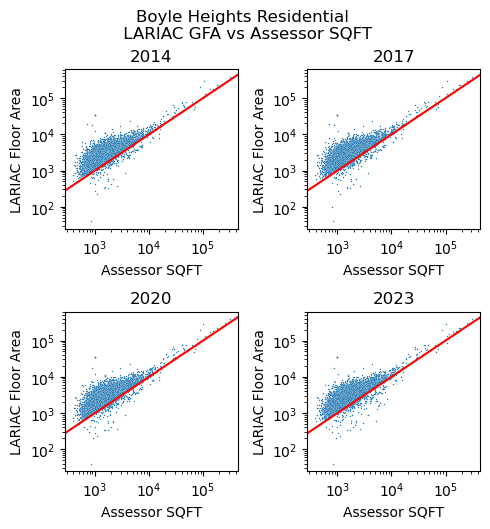

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes= plt.subplots(2,2, figsize=(5, 5))
axes = axes.flatten()
for index, ax in enumerate(axes):
    sns.scatterplot(data = laraic[index].query('UseType == "Residential"'), 
                    y = 'shape.floorarea', x = 'parcels.SQFTmain', 
                    s=1, ax = ax, legend = True)

    #unit line ab
    ax.axline((0, 0), slope=1., color='r', label='by slope')
    ax.set_title(f'{yr_str[index]}')
    ax.set_xlabel('Assessor SQFT')
    ax.set_ylabel('LARIAC Floor Area')
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()
plt.suptitle(f'{NAME} Residential \n LARIAC GFA vs Assessor SQFT', y=1.05)

Text(0.5, 1.05, 'Boyle Heights Residential \n LARIAC geomArea vs Assessor SQFT')

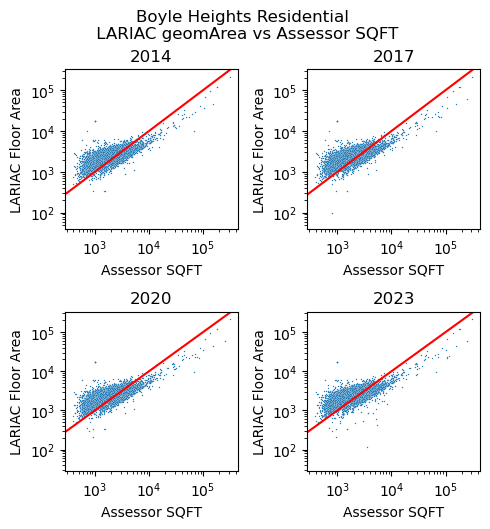

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes= plt.subplots(2,2, figsize=(5, 5))
axes = axes.flatten()
for index, ax in enumerate(axes):
    sns.scatterplot(data = laraic[index].query('UseType == "Residential"'), 
                    y = 'shape.area', x = 'parcels.SQFTmain', 
                    s=1, ax = ax, legend = True)

    #unit line ab
    ax.axline((0, 0), slope=1., color='r', label='by slope')
    ax.set_title(f'{yr_str[index]}')
    ax.set_xlabel('Assessor SQFT')
    ax.set_ylabel('LARIAC Floor Area')
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.tight_layout()
plt.suptitle(f'{NAME} Residential \n LARIAC geomArea vs Assessor SQFT', y=1.05)

In [155]:
import pandas as pd
laraic = [laraic[i].assign(year = yr_str[i]) for i in range(len(laraic))]
laraic = gpd.GeoDataFrame(pd.concat(laraic, ignore_index=True))

In [156]:
''' Filter with 1 records per YR & AIN '''
g = laraic.groupby('AIN')
g = g.filter(lambda x: len(x) == 4 and x['year'].nunique() == 4)



In [157]:
#check change in parcels.SQFTmain over time as TEST!

print('y2y n.Change in SQFTmain:', (g.groupby(['AIN','year'])['parcels.SQFTmain'].first().unstack().diff(axis = 1).fillna(0)!=0).sum(0))
print('y2y n.Change in nBuildings:',(g.groupby(['AIN','year'])['parcels.n_buildings'].first().unstack().diff(axis = 1).fillna(0)!=0).sum(0))


y2y n.Change in SQFTmain: year
2014      0
2017    144
2020    245
2023    404
dtype: int64
y2y n.Change in nBuildings: year
2014       0
2017       0
2020       0
2023    3888
dtype: int64


In [158]:
#check change in parcels.SQFTmain over time as TEST!

print('y2y N.change in SQFTmain:', (g.groupby(['AIN','year'])['shape.floorarea'].first().unstack().diff(axis = 1).fillna(0)!=0).sum(0))
print('y2y N.change in nBuildings:',(g.groupby(['AIN','year'])['shape.n_buildings'].first().unstack().diff(axis = 1).fillna(0)!=0).sum(0))


y2y N.change in SQFTmain: year
2014       0
2017    6185
2020    1102
2023       0
dtype: int64
y2y N.change in nBuildings: year
2014      0
2017    603
2020    480
2023      0
dtype: int64


In [159]:
#check change in parcels.SQFTmain over time as TEST!
g_d_floorarea = g.groupby(['AIN','year'])['shape.floorarea'].first().unstack().diff(axis = 1).fillna(0)

g_d_nbuildings = g.groupby(['AIN','year'])['shape.n_buildings'].first().unstack().diff(axis = 1).fillna(0)

In [160]:
from src.geoadmin import get_parcels_bygeom
NAME = 'Boyle Heights'
neighborhood = neighborhoods.query('name == @NAME')
prcl = get_parcels_bygeom(neighborhood)

In [ ]:
prcl['AIN'] = prcl['AIN'].astype(int)
prcl = prcl.set_index('AIN')

for y in ['14', '17', '20']:
    prcl[f'd{y}_nbuildings'] = g_d_nbuildings[f'20{y}']
    prcl[f'd{y}_floorarea'] = g_d_floorarea[f'20{y}']


Text(0.5, 1.0, 'Assessor Change in gross floor area from 2017 to 2020')

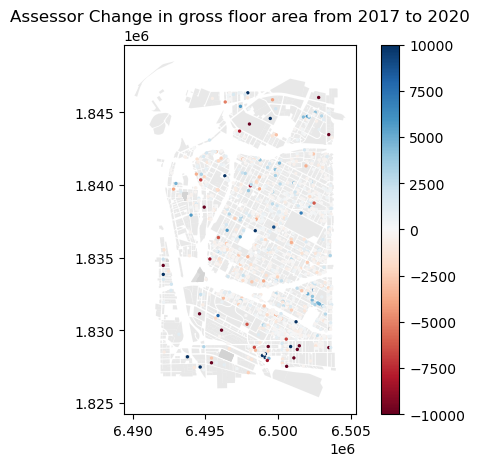

In [163]:
import matplotlib.pyplot as plt

ax = prcl.plot(color = 'lightgrey', alpha = .5)

(prcl
 .set_geometry(prcl.centroid)
 .query('abs(d20_floorarea) > 0')
 .plot(column = 'd20_floorarea', 
             legend = True,cmap = 'RdBu', 
             s = 2,ax = ax,
             vmin = -10000, vmax = 10000,
             ))
plt.title('Assessor Change in gross floor area from 2017 to 2020')

Text(0.5, 1.0, 'Assessor Change in number of buildings from 2017 to 2020')

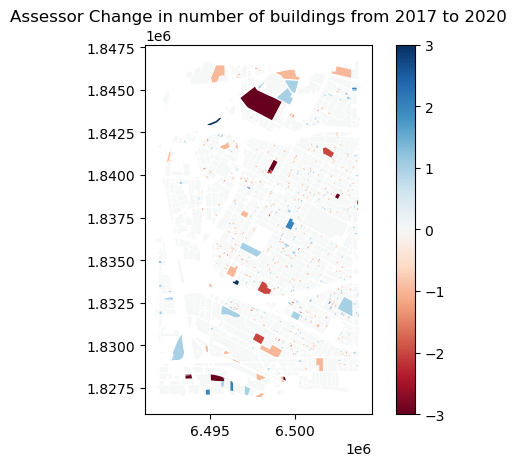

In [164]:
import matplotlib.pyplot as plt
prcl.plot(column = 'd20_nbuildings', 
             legend = True,cmap = 'RdBu', 
             vmin = -3, vmax = 3,)
plt.title('Assessor Change in number of buildings from 2017 to 2020')

Text(0.5, 1.0, 'LARIAC Change in geomArea from yr to yr \n (2023 is control)')

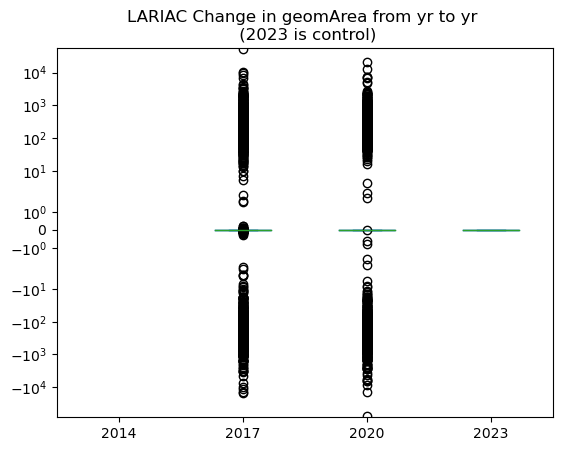

In [176]:
g.groupby(['AIN','year'])['shape.area'].first().unstack().diff(axis = 1).plot.box()

plt.yscale('symlog')
plt.title('LARIAC Change in geomArea from yr to yr \n (2023 is control)')

Text(0.5, 1.0, 'LARIAC Change in Gross Floor Area from yr to yr \n (2023 is control)')

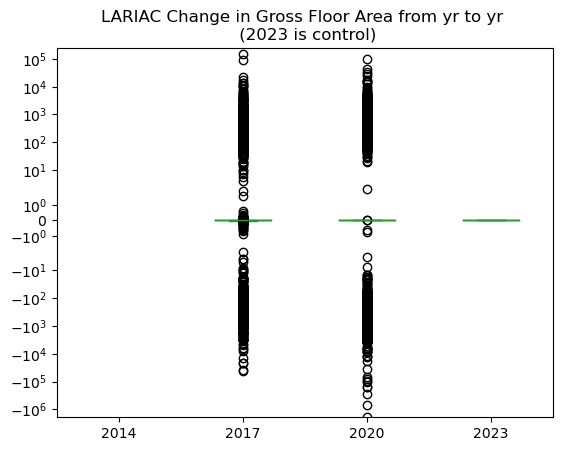

In [177]:
g.groupby(['AIN','year'])['shape.floorarea'].first().unstack().diff(axis = 1).plot.box()

plt.yscale('symlog')
plt.title('LARIAC Change in Gross Floor Area from yr to yr \n (2023 is control)')

<Axes: >

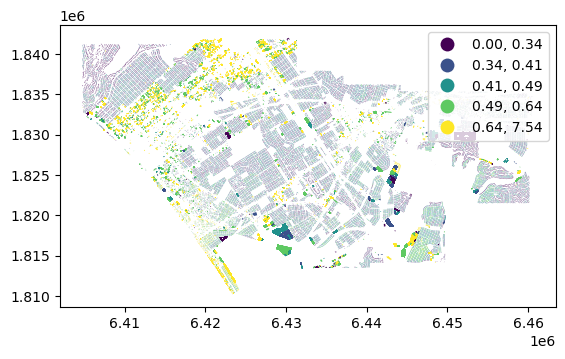

In [107]:
d.plot(column = 'sp.bar', cmap = 'viridis', legend = True, scheme = 'quantiles', k = 5)

In [167]:
import geopandas as gpd
def clip_by_pct(data,col, pct_l: float = .05, pct_u: float = .05) -> gpd.GeoDataFrame:
    """
    Clip the data by a given percentile.
    """
    
    return data[(data[col].rank(pct = True) > pct_l) & (data[col].rank(pct = True) < 1 - pct_u)]

/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/adamswietek/opt/anaconda3/envs/env_intel_sdb/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd

Text(0.5, 1.0, 'Residual Floor Area by year')

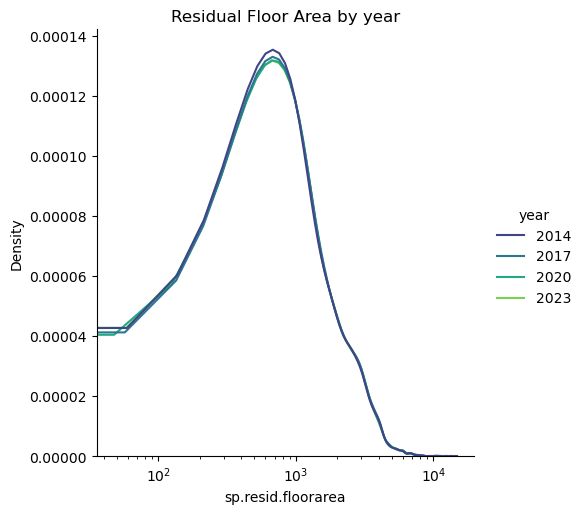

In [178]:
d = clip_by_pct(laraic, 'sp.resid.floorarea', 0.05, 0.05)
d = (d
    .assign(pArea = d['parcels.area'])
    .query('UseType == "Residential"')
    .query('pArea < 10000')
    # .query('')
    # .query('year == "2020"')
    )
    
sns.displot(data = d, x = 'sp.resid.floorarea', kind = 'kde',hue = 'year', palette = 'viridis')
plt.xscale('log')#, plt.xscale('log')

plt.title('Residual Floor Area by year')

Text(0.5, 1.0, 'Residual Floor Area by year 2020 \n (LARAIC GFA - Assessor SQFT)')

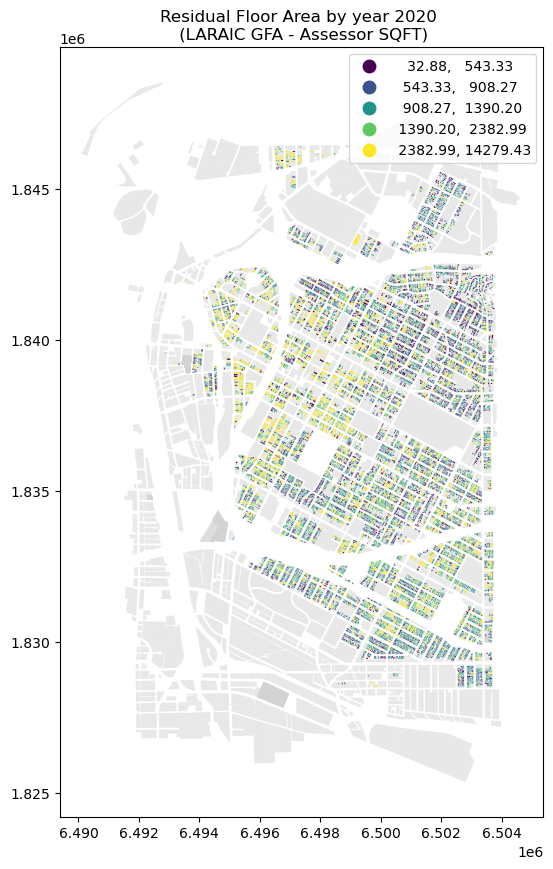

In [188]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 1, figsize=(10, 10))

prcl.plot(color = 'lightgrey', alpha = .5, ax = ax)
(d
 .query('year == "2020"')
 .plot(column = 'sp.resid.floorarea', 
       cmap = 'viridis', legend = True, scheme = 'quantiles', k = 5,
       ax = ax)
)

plt.title('Residual Floor Area by year 2020 \n (LARAIC GFA - Assessor SQFT)')

